In [1]:
# !conda install -c conda-forge tqdm -n TORCH_ENV_NAME
# !pip install torchinfo

import os
import sys
sys.path.append('lib')
import torch
import torch.nn as nn
import torch.optim as optim

import utils
from stock_data import stock_data
from RNN import RNN


# Pre-training

## Default values for training and testing

In [2]:
#* Get stocks list available
file_path_list = [file.path for file in os.scandir('data') if file.is_file()]
stocks_list = [file_path[file_path.find("/")+1:file_path.find("_")] for file_path in file_path_list]
STOCKS_LIST = sorted(set(stocks_list) - set(['all']))

#* Name of stock
STOCKS = "AMZN"
if STOCKS not in STOCKS_LIST:
    raise Exception("Given stocks col_name is not valid")

#* Set default precision
PRECISION = '32'
torch.set_default_dtype(getattr(torch, 'float' + PRECISION))

#* Recurrent Neural Network Type: Choosed between LSTM, GRU
RNN_TYPE = "LSTM"

#* Features to use: Choose between 'Open', 'Close', 'High', 'Low'
IN_FEATURES = ['Open', 'High', 'Low', 'Close',]
OUT_FEATURES = ['Open', 'High', 'Low']
IN_FEATURES, OUT_FEATURES = utils.check_features(IN_FEATURES, OUT_FEATURES)

#* prefix of model name: Full information of model
PREFIX = '_'.join([STOCKS, PRECISION, RNN_TYPE]) + "_"
PREFIX += ''.join([feature[0] for feature in IN_FEATURES]) + '2' + ''.join([feature[0] for feature in OUT_FEATURES])

#* Number of days to use prediction
PAST_LEN = 60
if PAST_LEN != 60:
    PREFIX += "_PL{}".format(PAST_LEN)

#* Number of days to predict
SUCCESSIVE_DAYS = 7
if SUCCESSIVE_DAYS > 1:
    PREFIX += "_SD{}".format(SUCCESSIVE_DAYS)

#* Drop out
DROPOUT = 0.2
if DROPOUT != 0.2:
    PREFIX += "_DO{:.2f}".format(DROPOUT)

#* Optimizer name
OPTIMIZER_NAME = 'RMSprop'
if OPTIMIZER_NAME != 'RMSprop':
    PREFIX += '_' + OPTIMIZER_NAME

#* Regularization for optimizer
L2_REGULARIZATION = 1e-4
if L2_REGULARIZATION:
    PREFIX += "_RG{}".format(L2_REGULARIZATION)


#* Scaler
SCALER_NAME = 'MinMaxScaler'
if SCALER_NAME != 'MinMaxScaler':
    PREFIX += '_' + SCALER_NAME

print("prefix:",PREFIX)

#* Whether to use pre-processed data
PRE_PROCESS = True
#* Check device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE


prefix: AMZN_32_LSTM_OHLC2OHL_SD7_RG0.0001


device(type='cuda', index=0)

## Generate dataset

In [3]:
data = stock_data(STOCKS, in_features=IN_FEATURES,
                  out_features=OUT_FEATURES,
                  past_len=PAST_LEN,
                  scaler_name=SCALER_NAME,
                  precision=PRECISION,
                  pre_process=PRE_PROCESS,
                  successive_days=SUCCESSIVE_DAYS,
                  verbose=True)
train_loader = data.get_train_loader(batch_size=64, num_workers=4)
val_loader = data.get_val_loader(batch_size=64)


Finished reading a file data/pre_32/AMZN.parquet.snappy
-----------------------------
Number of train set: 1946 with input: torch.Size([60, 4]) output: torch.Size([7, 3])
Number of validation set: 498 with input: torch.Size([60, 4]) output: torch.Size([7, 3])
Number of test set: 497 with input: torch.Size([60, 4]) output: torch.Size([7, 3])


## Define neural network, loss function, optimizer type

In [4]:
model = RNN(rnn_type=RNN_TYPE,
            in_features=IN_FEATURES,
            out_features=OUT_FEATURES,
            successive_days=SUCCESSIVE_DAYS,
            dropout=DROPOUT).to(DEVICE)
optimizer = getattr(optim, OPTIMIZER_NAME)(params=model.parameters(),
                                           lr=1e-3,
                                           weight_decay=L2_REGULARIZATION)

loss_func = nn.MSELoss()
utils.model_summary(model, input_size=(PAST_LEN, len(IN_FEATURES)), precision=PRECISION)


Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
├─LSTM: 1-1                              [1, 60, 4]       [1, 60, 50]      --               72,400           4,248,000
|    └─weight_ih_l0                                                        [200, 4]
|    └─weight_hh_l0                                                        [200, 50]
|    └─weight_ih_l1                                                        [200, 50]
|    └─weight_hh_l1                                                        [200, 50]
|    └─weight_ih_l2                                                        [200, 50]
|    └─weight_hh_l2                                                        [200, 50]
|    └─weight_ih_l3                                                        [200, 50]
|    └─weight_hh_l3                                                        [200, 50]
├─Linear: 1-2                            [1, 50]          [1, 21]          [50, 21]

## Load model if needed

In [5]:
#* Load model
epoch = 50

checkpoint = torch.load(os.path.join('model', PREFIX + '_{}.pth'.format(epoch)), map_location=DEVICE)
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']


# Training

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train finished with 81.634408 seconds


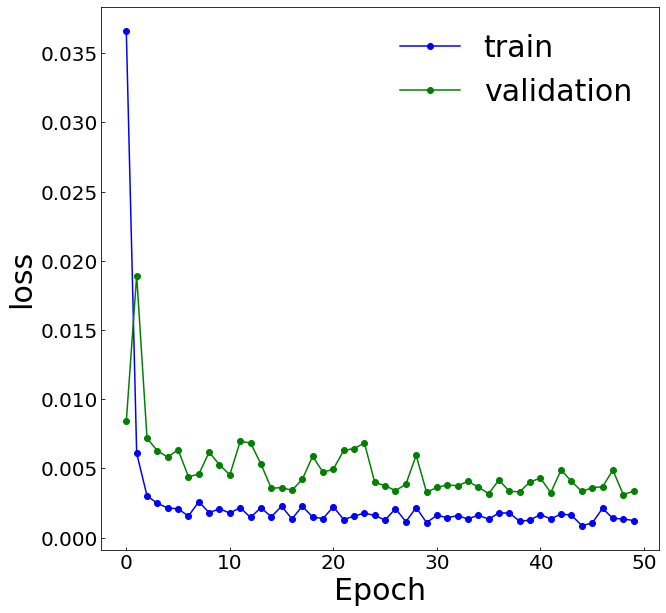

In [13]:
epoch = 50
history = utils.train(model,
                     max_epoch=epoch,
                     loss_func=loss_func,
                     optimizer=optimizer,
                     train_loader=train_loader,
                     val_loader=val_loader,
                     verbose=False)
utils.plot_loss(*history)


# Test

Average test finished with 1.05 seconds
Loss: 0.002382
Recurrent test finished with 1.06 seconds
Loss: 0.002064


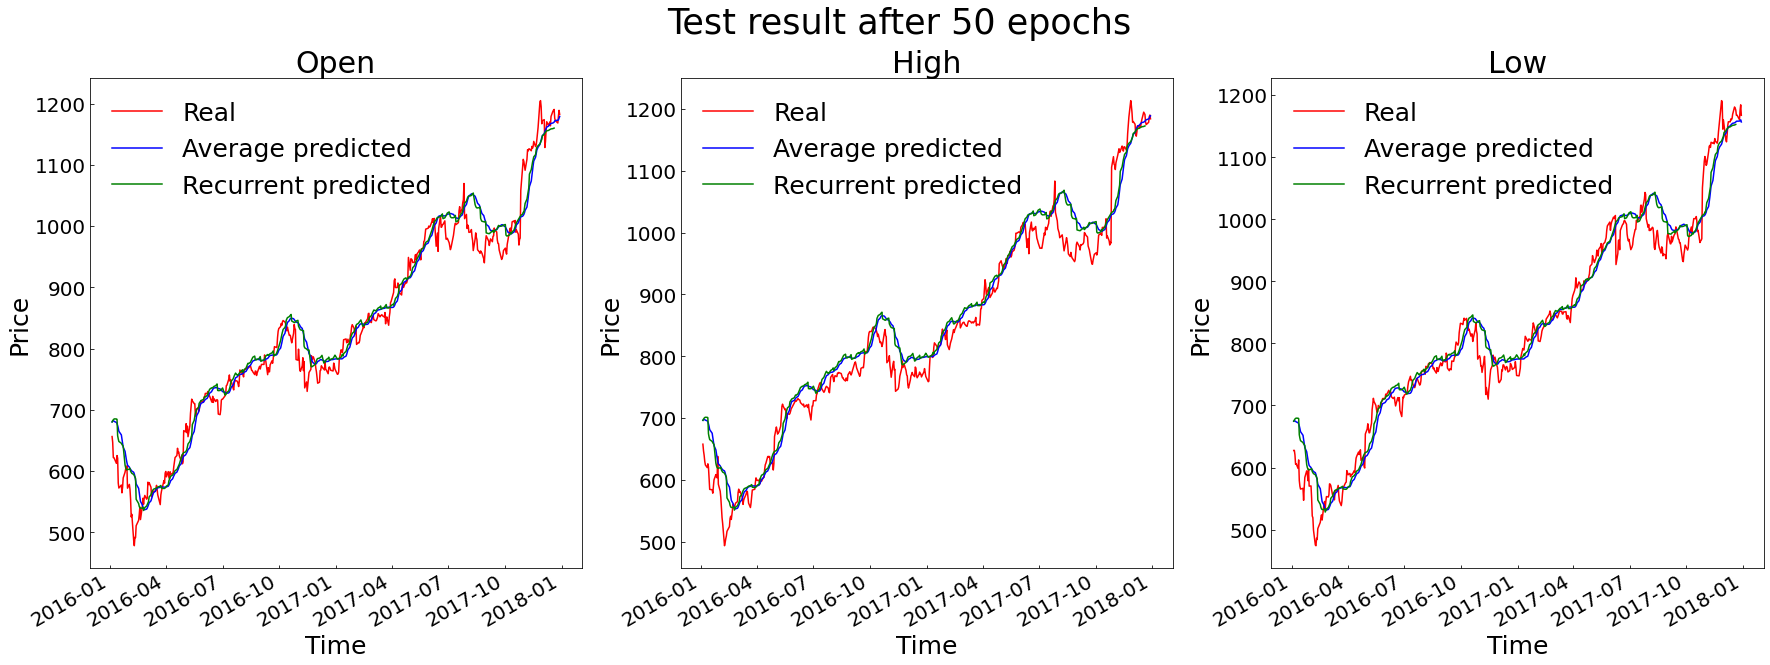

In [6]:
avg_prediction = utils.average_test(model, data,
                                    loss_func=loss_func,
                                    verbose=True)
recurrent_prediction = utils.recurrent_test(model, data,
                                            loss_func=loss_func,
                                            verbose=True)

utils.plot_prediction(data=data,
                      epoch=epoch,
                      avg_prediction=avg_prediction,
                      recurrent_prediction=recurrent_prediction,
                      save_path=os.path.join('fig', PREFIX + "_prediction.png"))


# Save the model

In [29]:
#* Save the model with current state
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func},
           os.path.join('model', PREFIX + '_{}.pth'.format(epoch))
           )

RNN(
  (rnn): LSTM(4, 50, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=21, bias=True)
)